In [1]:
from pathlib import Path
from python.optimization import TopOpt2D
from python.postprocessor import PostProcessor

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("D:/SOMP_Ansys/python/")
res_dir    = Path("D:/SOMP_Ansys/results/")
mod_dir    = Path("D:/SOMP_Ansys/models/")
TopOpt2D.load_paths(ANSYS_path, script_dir, res_dir, mod_dir)
TopOpt2D.set_processors(4)

# Base
- Half MBB 168 mm x 80 mm (8 mm thick)
- Mesh: 42 x 20 elements (4 mm each)
- 1 N downward force


- Cellulose and 0.5 bamboo
- volfrac = 0.3
- rmin = 1.5
- theta0 = -45°

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex  = Efiber*Vfiber + Ematrix*Vmatrix
Ey  = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nu  = vfiber*Vfiber + vmatrix*Vmatrix
rho = rhofiber*Vfiber + rhomatrix*Vmatrix

In [3]:
solver1 = TopOpt2D(inputfile='mbb2d', Ex=Ex, Ey=Ey, Gxy=Gxy, nu=nu, volfrac=0.3, rmin=6, theta0=-45, jobname='-30')
solver1.optim()

print('\nElapsed time: {:.2f}s'.format(solver1.time))
print('FEA time: {:.2f}s'.format(solver1.mma.fea_time))

Starting iteration   1... compliance = 0.0407
Starting iteration   2... compliance = 0.0272
Starting iteration   3... compliance = 0.0198
Starting iteration   4... compliance = 0.0163
Starting iteration   5... compliance = 0.0140

Elapsed time: 40.19s
FEA time: 32.76s


CO2 footprint: 333.60 kgCO2


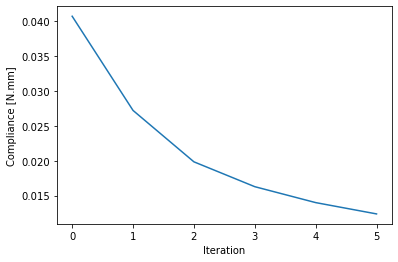

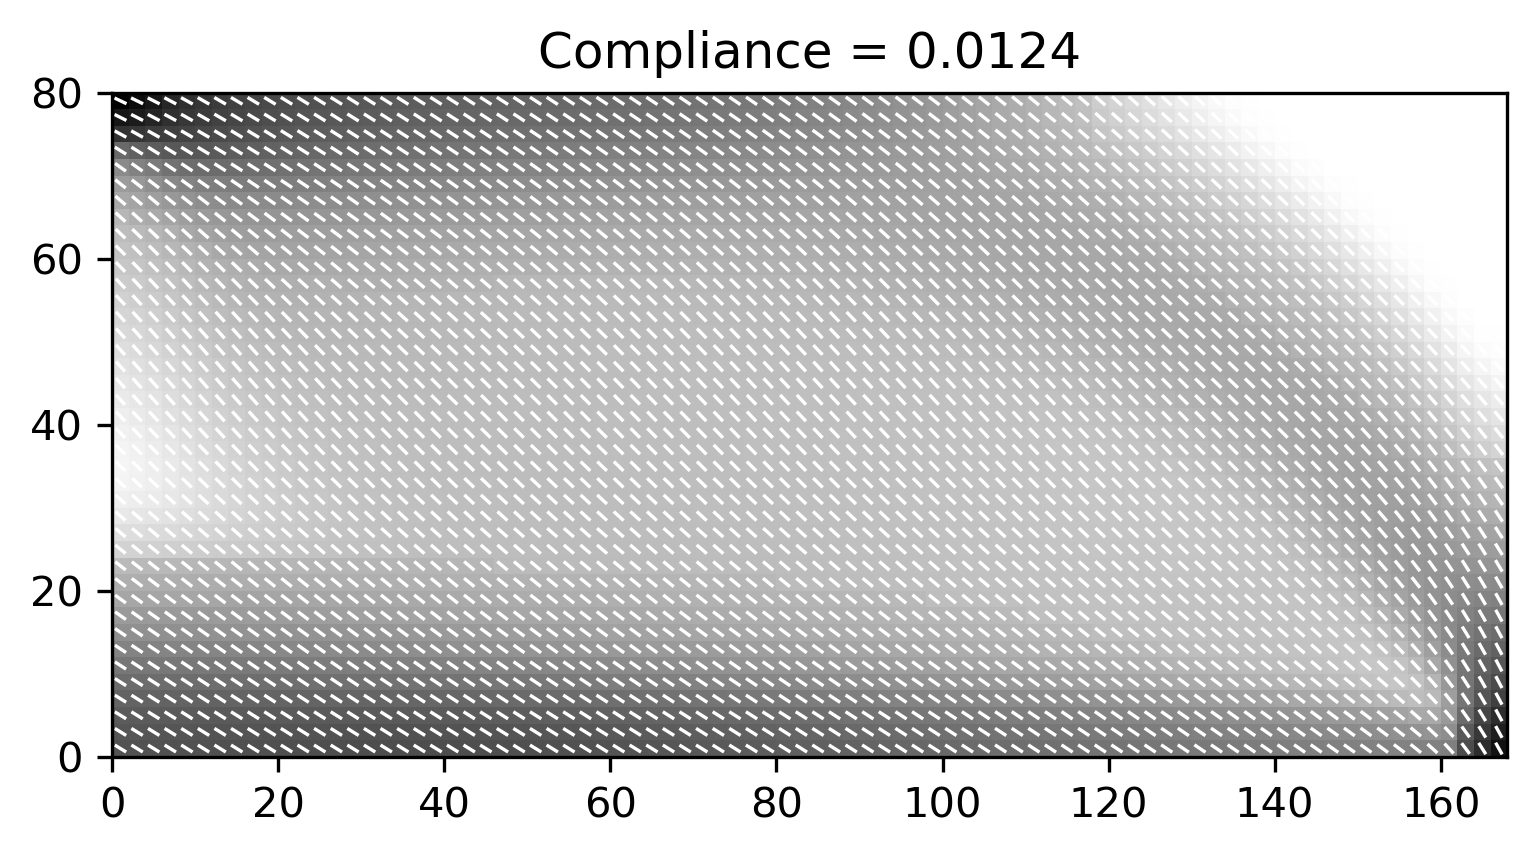

In [4]:
post1 = PostProcessor(solver1)
post1.plot_convergence()
post1.plot()

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post1.CO2_footprint(rho, CO2mat, CO2veh)))

In [5]:
# Clear temporary files
import os, glob
for filename in glob.glob("file*"): os.remove(filename)
for filename in glob.glob("cleanup*"): os.remove(filename)
del filename